<center><h1>Challenge RNN

In this challenge, the gaol is to train a classifier for sequences of genetic code.

Each sequence is represented by a string of letters [‘A’, ‘C’, ‘G’, ’T’] and belongs to one of five categories/classes labelled [0,…,4].

For training purposes, you will find 400 labelled sequences, each of length 400 characters (sequences: **data_x**, labels: **data_y**).

To validate your model, you have a further 100 labelled sequences (**val_x**, **val_y**) with 1200 characters each.

Finally, you have 250 unlabeled sequences (**test_x**, 2000 characters) which need to be classified.

Hint: Training recurrent networks is very expensive! Do not start working on this challenge too late or you might not manage to finish in time.

Your task is to train an RNN-based classifier and make a prediction for the missing labels of the test set (**test_x** in the attached archive). Store your prediction as a one-dimensional **numpy.ndarray**, save this array as **prediction.npy**, and upload this file to the whiteboard.

To load  the data and save your prediction, please refer to the following code snippet:

In [1]:
import numpy as np

with open('rnn-challenge-data.npz', 'rb') as f:
    X = np.load(f)
    data_x = X['data_x']
    data_y = X['data_y']
    val_x = X['val_x']
    val_y = X['val_y']
    test_x = X['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# VALIDATION DATA: INPUT (x) AND OUTPUT (y)
print(val_x.shape, val_x.dtype)
print(val_y.shape, val_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

(400,) <U400
(400,) int64
(100,) <U1200
(100,) int64
(250,) <U2000


In [2]:
# Printing one for having an idea
print(data_x[0])

CTAGCTGAGCTACTGAGCTACAGTTGACTGACCAGTCAGTGCTAGCTACTGACAGTCTGACAGTTGACCTGACTGATGACCAGTCTAGCAGTGCTACTAGCTAGGCTACAGTCAGTTGACCAGTCTGACAGTCAGTCTGACTGACAGTCAGTCTAGGCTATGACCTGACTGATGACCTGACTGACTGACAGTCTGACTGATGACGCTATGACCTGACTAGCTAGCAGTTGACTGACCTGACAGTGCTACTAGCAGTTGACCAGTGCTACAGTCTGATGACTGACCTGACAGTCTAGGCTACAGTTGACCTGACAGTCAGTGCTACTGACAGTCTAGTGACCAGTCAGTCAGTTGACCTGACTAGCAGTTGACGCTATGACCAGTCTGACAGTGCTACTAG


# Code
We could try
* Simple RNN
* LSTM

In [3]:
import torch
import torch.nn as nn

import time
import math

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

<center>Here making us of this tutorial : [NLP From Scratch: Classifying Names with a Character level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) (from Pytorch)</center>

## Preparing the data

In [4]:
n_categories = 5              # [0, 1, 2, 3, 4]

all_letters = 'ACGT' # string.ascii
n_letters = len(all_letters)
# Note that the two last lines could be maybe simpler with n_letters = 4 and giving just the list

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Testing that everything works
print(letterToTensor('A'))
print(lineToTensor('ACGTTAGC').size())

tensor([[1., 0., 0., 0.]])
torch.Size([8, 1, 4])


Turning all the data to tensors:

In [6]:
data_x_torch = torch.stack([lineToTensor(data_x[i]) for i in range(len(data_x))])
val_x_torch = torch.stack([lineToTensor(val_x[i]) for i in range(len(val_x))])
test_x_torch = torch.stack([lineToTensor(test_x[i]) for i in range(len(test_x))])

data_y_torch = torch.from_numpy(data_y)
val_y_torch = torch.from_numpy(val_y)

## Creating the model

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

## Training

In [8]:
# Initializing the network, trying with a single letter
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-1.6278, -1.6485, -1.5223, -1.6879, -1.5694]],
       grad_fn=<LogSoftmaxBackward>)


In [9]:
# Trying with a sequence
input = data_x_torch[1]
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-1.5989, -1.7224, -1.5921, -1.5640, -1.5778]],
       grad_fn=<LogSoftmaxBackward>)


In [10]:
# Helper function for classification
def categoryFromOutput(output):
    _, top_i = output.topk(1)
    return top_i[0].item()

print(categoryFromOutput(output))

3


In [11]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [12]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
# n_iters = 100000
epochs = 200
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

# train_ds = torch.utils.data.TensorDataset(data_x_torch, data_y_torch)
# train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# for epoch in range(epochs):
    
#     output, loss = train(category_tensor, line_tensor)
#     current_loss += loss


# Let's try with 1 epoch
for category, line_tensor in tqdm(zip(data_y, data_x_torch)):
    output, loss = train(torch.tensor([category]), line_tensor)

    all_losses.append(loss)

0it [00:00, ?it/s]

Output: tensor([[-1.6144, -1.6876, -1.5271, -1.5817, -1.6438]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5213, -1.8371, -1.6051, -1.5436, -1.5710]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5639, -1.7723, -1.4944, -1.7096, -1.5351]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5271, -1.8436, -1.5624, -1.5757, -1.5698]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5280, -1.8222, -1.4939, -1.7371, -1.5103]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5342, -1.7818, -1.5175, -1.6976, -1.5434]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5372, -1.7866, -1.5232, -1.6778, -1.5479]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5473, -1.9077, -1.5796, -1.5539, -1.5085]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5314, -1.9159, -1.5788, -1.5547, -1.5183]],
       grad_fn=<LogSoftmaxBackward>)
Output: tensor([[-1.5555, -1.7992, -1.5111, -1.6798, -1.5306]],
       grad_fn=<LogSoftmaxB

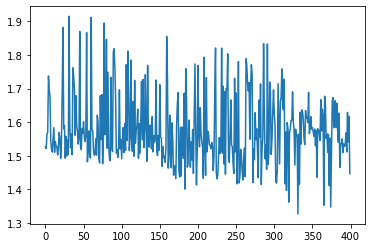

In [15]:
# Plotting the loss
plt.figure()
plt.plot(all_losses)

# Prediction and submission

In [ ]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 250

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))

# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (250, )
    assert loaded.dtype == int
    assert (loaded <= 4).all()
    assert (loaded >= 0).all()
validate_prediction_format()

**accuracy** → **points**<br>
≥95% → 10<br>
≥90% → 7<br>
≥85% → 5